# ML & PR Group Work 

## Kindgdom prediction trough codon frequencies

### Alexander Moor, Brigitta Barta, Philipp Tschannen, Curdin Bosshart

In [24]:
import pandas as pd 
import umap
import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from time import time
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from skopt import BayesSearchCV

In [25]:
df = pd.read_csv("codon_usage.csv")
df.columns

C:\Users\tscha\AppData\Local\Temp\ipykernel_13144\1036650832.py:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("codon_usage.csv")


Index(['Kingdom', 'DNAtype', 'SpeciesID', 'Ncodons', 'SpeciesName', 'UUU',
       'UUC', 'UUA', 'UUG', 'CUU', 'CUC', 'CUA', 'CUG', 'AUU', 'AUC', 'AUA',
       'AUG', 'GUU', 'GUC', 'GUA', 'GUG', 'GCU', 'GCC', 'GCA', 'GCG', 'CCU',
       'CCC', 'CCA', 'CCG', 'UGG', 'GGU', 'GGC', 'GGA', 'GGG', 'UCU', 'UCC',
       'UCA', 'UCG', 'AGU', 'AGC', 'ACU', 'ACC', 'ACA', 'ACG', 'UAU', 'UAC',
       'CAA', 'CAG', 'AAU', 'AAC', 'UGU', 'UGC', 'CAU', 'CAC', 'AAA', 'AAG',
       'CGU', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG', 'GAU', 'GAC', 'GAA', 'GAG',
       'UAA', 'UAG', 'UGA'],
      dtype='object')

Removing all columns that arent relevant for prediction

In [26]:
columns_to_drop = ['DNAtype', 'SpeciesID', 'Ncodons', 'SpeciesName']
df = df.drop(columns_to_drop, axis=1)
df

,Kingdom,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0.01654,0.01203,0.00050,0.00351,0.01203,0.03208,0.00100,0.04010,0.00551,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,vrl,0.02714,0.01357,0.00068,0.00678,0.00407,0.02849,0.00204,0.04410,0.01153,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,vrl,0.01974,0.0218,0.01357,0.01543,0.00782,0.01111,0.01028,0.01193,0.02283,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,vrl,0.01775,0.02245,0.01619,0.00992,0.01567,0.01358,0.00940,0.01723,0.02402,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,vrl,0.02816,0.01371,0.00767,0.03679,0.01380,0.00548,0.00473,0.02076,0.02716,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13023,pri,0.02552,0.03555,0.00547,0.01367,0.01276,0.02097,0.00820,0.03555,0.01459,...,0.00820,0.01367,0.01094,0.01367,0.02279,0.02005,0.04102,0.00091,0.00091,0.00638
13024,pri,0.01258,0.03193,0.01984,0.00629,0.01451,0.05322,0.07644,0.01258,0.03096,...,0.00145,0.00000,0.00048,0.00194,0.01306,0.01838,0.00677,0.00242,0.00097,0.01887
13025,pri,0.01423,0.03321,0.01661,0.00356,0.01127,0.05042,0.09609,0.01068,0.02728,...,0.00000,0.00000,0.00000,0.00178,0.01661,0.02788,0.00297,0.00356,0.00119,0.02017
13026,pri,0.01757,0.02028,0.00767,0.01293,0.01319,0.01959,0.00715,0.03964,0.01600,...,0.01142,0.01217,0.01196,0.02178,0.02510,0.02896,0.03959,0.00099,0.00079,0.00156


Remove the two columns that are entered incorrectly and have Kingdom names in a codon fequenc column

In [27]:
# Convert all columns except 'Kingdom' to numeric, coerce errors to NaN
df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values
df = df.dropna()

df

,Kingdom,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0.01654,0.01203,0.00050,0.00351,0.01203,0.03208,0.00100,0.04010,0.00551,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,vrl,0.02714,0.01357,0.00068,0.00678,0.00407,0.02849,0.00204,0.04410,0.01153,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,vrl,0.01974,0.0218,0.01357,0.01543,0.00782,0.01111,0.01028,0.01193,0.02283,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,vrl,0.01775,0.02245,0.01619,0.00992,0.01567,0.01358,0.00940,0.01723,0.02402,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,vrl,0.02816,0.01371,0.00767,0.03679,0.01380,0.00548,0.00473,0.02076,0.02716,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13023,pri,0.02552,0.03555,0.00547,0.01367,0.01276,0.02097,0.00820,0.03555,0.01459,...,0.00820,0.01367,0.01094,0.01367,0.02279,0.02005,0.04102,0.00091,0.00091,0.00638
13024,pri,0.01258,0.03193,0.01984,0.00629,0.01451,0.05322,0.07644,0.01258,0.03096,...,0.00145,0.00000,0.00048,0.00194,0.01306,0.01838,0.00677,0.00242,0.00097,0.01887
13025,pri,0.01423,0.03321,0.01661,0.00356,0.01127,0.05042,0.09609,0.01068,0.02728,...,0.00000,0.00000,0.00000,0.00178,0.01661,0.02788,0.00297,0.00356,0.00119,0.02017
13026,pri,0.01757,0.02028,0.00767,0.01293,0.01319,0.01959,0.00715,0.03964,0.01600,...,0.01142,0.01217,0.01196,0.02178,0.02510,0.02896,0.03959,0.00099,0.00079,0.00156


In [28]:
label_mapping = {
    'bct': 'bct',  # Eubacteria proper
    'arc': 'arc',  # Archaea
    'plm': 'bct',  # Plasmids to bacteria
    'inv': 'Eukarya',  # Invertebrates
    'mam': 'Eukarya',  # Mammals
    'pln': 'Eukarya',  # Plants
    'pri': 'Eukarya',  # Primates
    'rod': 'Eukarya',  # Rodents
    'vrt': 'Eukarya',  # Vertebrates
    'phg': 'vrl',      #bacteriophage to virus
}

# Example DataFrame

df = pd.DataFrame(df)

# Replace old labels with new labels in the 'Kingdom' column
df['Kingdom'] = df['Kingdom'].replace(label_mapping)

df

,Kingdom,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0.01654,0.01203,0.00050,0.00351,0.01203,0.03208,0.00100,0.04010,0.00551,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,vrl,0.02714,0.01357,0.00068,0.00678,0.00407,0.02849,0.00204,0.04410,0.01153,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,vrl,0.01974,0.0218,0.01357,0.01543,0.00782,0.01111,0.01028,0.01193,0.02283,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,vrl,0.01775,0.02245,0.01619,0.00992,0.01567,0.01358,0.00940,0.01723,0.02402,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,vrl,0.02816,0.01371,0.00767,0.03679,0.01380,0.00548,0.00473,0.02076,0.02716,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13023,Eukarya,0.02552,0.03555,0.00547,0.01367,0.01276,0.02097,0.00820,0.03555,0.01459,...,0.00820,0.01367,0.01094,0.01367,0.02279,0.02005,0.04102,0.00091,0.00091,0.00638
13024,Eukarya,0.01258,0.03193,0.01984,0.00629,0.01451,0.05322,0.07644,0.01258,0.03096,...,0.00145,0.00000,0.00048,0.00194,0.01306,0.01838,0.00677,0.00242,0.00097,0.01887
13025,Eukarya,0.01423,0.03321,0.01661,0.00356,0.01127,0.05042,0.09609,0.01068,0.02728,...,0.00000,0.00000,0.00000,0.00178,0.01661,0.02788,0.00297,0.00356,0.00119,0.02017
13026,Eukarya,0.01757,0.02028,0.00767,0.01293,0.01319,0.01959,0.00715,0.03964,0.01600,...,0.01142,0.01217,0.01196,0.02178,0.02510,0.02896,0.03959,0.00099,0.00079,0.00156


Perform UMAP for data visualization 

In [29]:
df["Kingdom"].unique()

array(['vrl', 'arc', 'bct', 'Eukarya'], dtype=object)

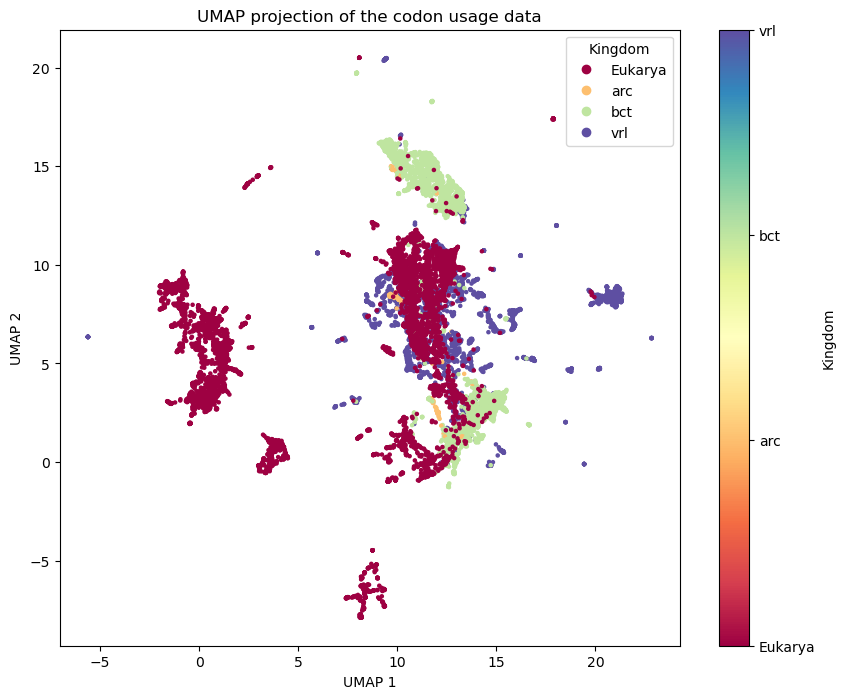

In [30]:
# Convert all features to numeric, coerce errors to NaN, and drop rows with NaN values
features = df.drop('Kingdom', axis=1)
features = features.apply(pd.to_numeric, errors='coerce')
features = features.dropna()

# Align labels with the filtered features
labels = df['Kingdom'].loc[features.index]

# Convert labels to a categorical type
labels = labels.astype('category')

# Fit and transform the data using UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(features)

# Create a scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=labels.cat.codes.to_numpy(),  # Convert categories to numeric codes
    cmap='Spectral',
    s=5
)

# Add colorbar with categories
colorbar = plt.colorbar(scatter, ticks=range(len(labels.cat.categories)))
colorbar.ax.set_yticklabels(labels.cat.categories)
colorbar.set_label('Kingdom')

plt.title('UMAP projection of the codon usage data')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Create a legend
handles, _ = scatter.legend_elements()
plt.legend(handles, labels.cat.categories, title="Kingdom")

plt.show()


Perform Min Max scaling

In [31]:
columns_to_scale = df.columns[1:] 
scaler = MinMaxScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
df

,Kingdom,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0.076116,0.131203,0.003304,0.034687,0.133994,0.319681,0.006101,0.373475,0.035765,...,0.081203,0.131843,0.609105,0.054023,0.405130,0.083029,0.275055,0.055531,0.019524,0.000000
1,vrl,0.124896,0.147999,0.004493,0.067003,0.045333,0.283906,0.012445,0.410729,0.074841,...,0.024487,0.171608,0.615437,0.065765,0.399245,0.107668,0.278146,0.059956,0.026552,0.000000
2,vrl,0.090842,0.237758,0.089672,0.152485,0.087102,0.110713,0.062714,0.111111,0.148189,...,0.107310,0.199737,0.425980,0.168372,0.178848,0.154738,0.155661,0.086504,0.000000,0.013496
3,vrl,0.081684,0.244847,0.106985,0.098033,0.174538,0.135326,0.057345,0.160473,0.155913,...,0.065898,0.142669,0.285983,0.202521,0.169712,0.209055,0.217345,0.057743,0.061304,0.000000
4,vrl,0.129590,0.149526,0.050684,0.363573,0.153709,0.054609,0.028856,0.193350,0.176295,...,0.108750,0.151169,0.296765,0.223419,0.218113,0.231831,0.232040,0.000000,0.017181,0.012277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13023,Eukarya,0.117441,0.387719,0.036146,0.135092,0.142125,0.208969,0.050024,0.331098,0.094703,...,0.147641,0.138318,0.187233,0.073629,0.200193,0.138381,0.258720,0.020133,0.035533,0.059794
13024,Eukarya,0.057892,0.348239,0.131104,0.062160,0.161617,0.530344,0.466325,0.117165,0.200961,...,0.026107,0.000000,0.008215,0.010449,0.114722,0.126855,0.042699,0.053540,0.037876,0.176851
13025,Eukarya,0.065486,0.362199,0.109760,0.035181,0.125529,0.502441,0.586201,0.099469,0.177074,...,0.000000,0.000000,0.000000,0.009587,0.145907,0.192422,0.018732,0.078761,0.046466,0.189035
13026,Eukarya,0.080856,0.221180,0.050684,0.127779,0.146915,0.195217,0.043619,0.369191,0.103856,...,0.205618,0.123141,0.204689,0.117311,0.220485,0.199876,0.249700,0.021903,0.030847,0.014620


visualize again

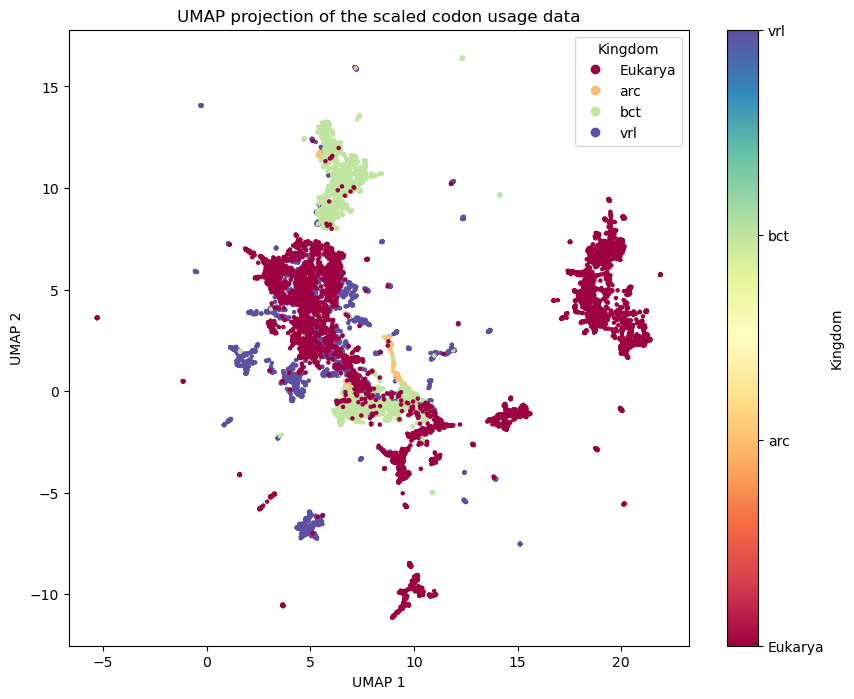

In [32]:
features = df.drop('Kingdom', axis=1)
features = features.apply(pd.to_numeric, errors='coerce')
features = features.dropna()

# Align labels with the filtered features
labels = df['Kingdom'].loc[features.index]

# Convert labels to a categorical type
labels = labels.astype('category')

# Fit and transform the data using UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(features)

# Create a scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=labels.cat.codes.to_numpy(),  # Convert categories to numeric codes
    cmap='Spectral',
    s=5
)

# Add colorbar with categories
colorbar = plt.colorbar(scatter, ticks=range(len(labels.cat.categories)))
colorbar.ax.set_yticklabels(labels.cat.categories)
colorbar.set_label('Kingdom')

plt.title('UMAP projection of the scaled codon usage data')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Create a legend
handles, _ = scatter.legend_elements()
plt.legend(handles, labels.cat.categories, title="Kingdom")

plt.show()

### Class Distributions 

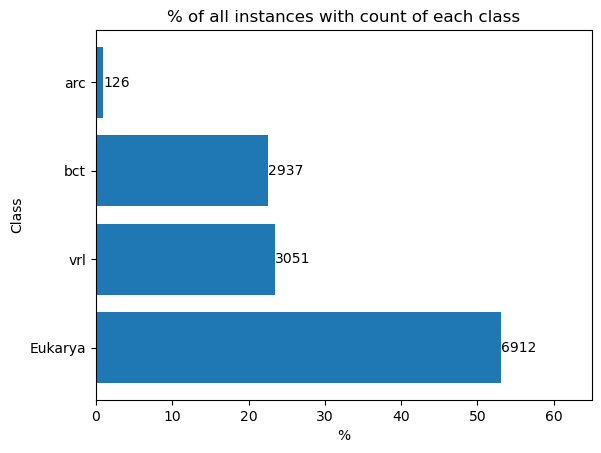

In [33]:
temp = df["Kingdom"].value_counts()
percentages = temp / len(df["Kingdom"]) * 100

plt.barh(temp.index, percentages.values)
plt.title('% of all instances with count of each class')
plt.xlabel('%')
plt.ylabel('Class')
plt.xlim(0, 65)

# Add text annotations at the end of the bars
for index, value in enumerate(percentages.values):
    count = temp.values[index]
    plt.text(value, index, f'{count}', va='center', ha='left')

plt.show()


There are strong imbalences between calsses
to rectify this problem we performed SMOTE

### SMOTE

In [34]:
X = df.drop(["Kingdom"], axis = 1).values
y = LabelEncoder().fit_transform(df['Kingdom'])

print(X.shape)
print(y.shape)

(13026, 64)
(13026,)


In [35]:
X_resampled, y_resampled = SMOTE(sampling_strategy= "not majority").fit_resample(X, y)

print(X_resampled.shape)
print(y_resampled.shape)

(27648, 64)
(27648,)


### Creating a XGBoost Classifier and parameter optimization with BayesSearch

In [36]:
opt = BayesSearchCV(
    XGBClassifier(),
    {
    'max_depth': (3, 18),  # integer valued parameter
    'learning_rate': (1e-4, 0.3, 'log-uniform'),  # log-uniform: vary learning rate exponentially
    'n_estimators': (50, 500),  # integer valued parameter
    'gamma': (1e-6, 9, 'log-uniform'),  # log-uniform: vary gamma exponentially
    'min_child_weight': (0, 10),  # integer valued parameter
    'subsample': (0.5, 1.0),  # uniform distribution
    'colsample_bytree': (0.5, 1.0),  # uniform distribution
    'reg_alpha': (1e-6, 10, 'log-uniform'),  # L1 regularization
    'reg_lambda': (1e-6, 10, 'log-uniform'),  # L2 regularization
    },
    n_iter=25,
    cv=5
)

start = time()
opt.fit(X_resampled, y_resampled)
print("time:", time() - start)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("Optimal parameters: %s" % opt.best_params_)

time: 3296.7246582508087
val. score: 0.9784806005618247


NameError: name 'X_test' is not defined

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, stratify= y_resampled, test_size= 0.3)
print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("Optimal parameters: %s" % opt.best_params_)

val. score: 0.9784806005618247
test score: 1.0
Optimal parameters: OrderedDict({'colsample_bytree': 0.9396345295388627, 'gamma': 0.021069674827259122, 'learning_rate': 0.11078724421808636, 'max_depth': 14, 'min_child_weight': 3, 'n_estimators': 419, 'reg_alpha': 6.762899531230331e-06, 'reg_lambda': 2.2475942107246287, 'subsample': 0.9949406236502526})


Run Model with best parameters

In [32]:
best_params = {
    'colsample_bytree': 0.8857781478235609,
    'gamma': 5.829498728872856e-06,
    'learning_rate': 0.2772019263304506,
    'max_depth': 14,
    'min_child_weight': 3,
    'n_estimators': 177,
    'reg_alpha': 0.10465113394009344,
    'reg_lambda': 8.831902263633859,
    'subsample': 0.7851661145758986
}

# Create the XGBClassifier with the specified parameters
model = XGBClassifier(**best_params)

n_splits = 5  # Number of folds
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)

# Perform cross-validation
scores = cross_val_score(model, X_resampled, y_resampled, cv=stratified_kfold, scoring='accuracy')

# Display the scores
print(f"Accuracy scores for each fold: {scores}")
print(f"Mean accuracy: {np.mean(scores):.4f}")
print(f"Standard deviation of accuracy: {np.std(scores):.4f}")

Accuracy scores for each fold: [0.98069137 0.97757708 0.98037994 0.97960137 0.97975393]
Mean accuracy: 0.9796
Standard deviation of accuracy: 0.0011


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, stratify= y_resampled, test_size= 0.3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Accuracy Score optimized Model : {accuracy_score(y_test, y_pred)}")

Accuracy Score optimized Model : 0.9777846984324717


Display Confusion Matrix to see if any classes are mislabeld disproportionately

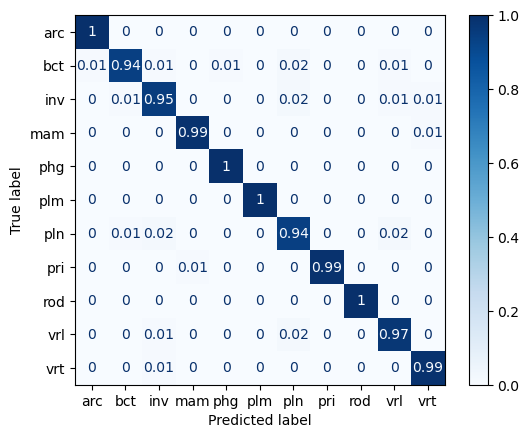

In [37]:
cm = confusion_matrix(y_test, y_pred)
# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.around(cm_normalized, decimals=2)

# Display the normalized and rounded confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=LabelEncoder().fit(df['Kingdom']).classes_)
disp.plot(cmap='Blues')
plt.show()

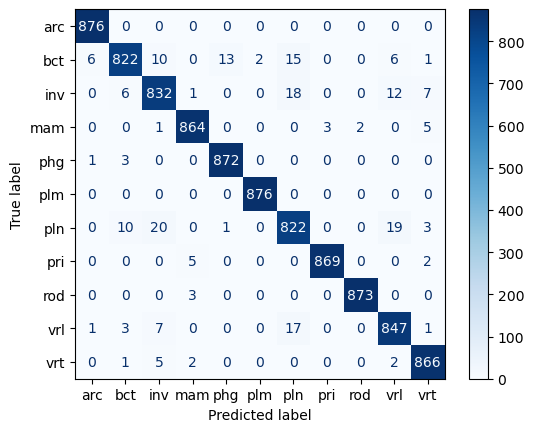

In [38]:
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LabelEncoder().fit(df['Kingdom']).classes_)
disp.plot(cmap='Blues')
plt.show()

Now test the model on the original data set without SMOTE

In [41]:
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,  test_size= 0.3)
    y_pred = model.predict(X_test)
    print(f"Accuracy Score optimized Model : {accuracy_score(y_test, y_pred)}")

Accuracy Score optimized Model : 0.9831115660184238
Accuracy Score optimized Model : 0.984646878198567
Accuracy Score optimized Model : 0.9851586489252815
Accuracy Score optimized Model : 0.9851586489252815
Accuracy Score optimized Model : 0.9851586489252815


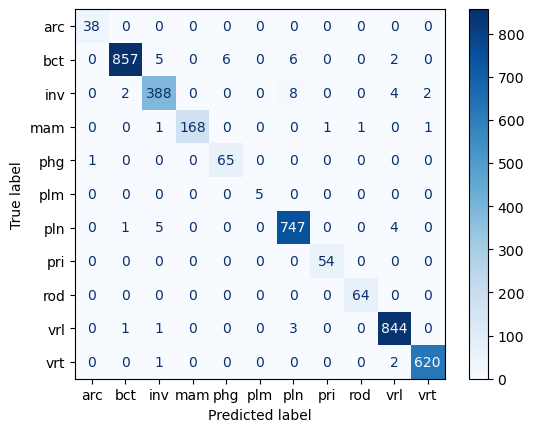

In [42]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LabelEncoder().fit(df['Kingdom']).classes_)
disp.plot(cmap='Blues')
plt.show()

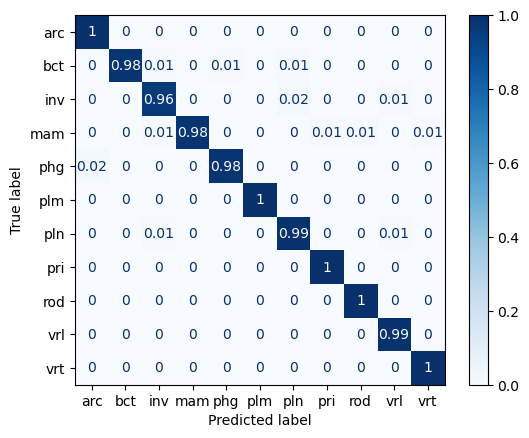

In [43]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.around(cm_normalized, decimals=2)

# Display the normalized and rounded confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=LabelEncoder().fit(df['Kingdom']).classes_)
disp.plot(cmap='Blues')
plt.show()

### Comparison to if the same model aproach is taken without SMOTE

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3)

opt = BayesSearchCV(
    XGBClassifier(),
    {
    'max_depth': (3, 18),  # integer valued parameter
    'learning_rate': (1e-4, 0.3, 'log-uniform'),  # log-uniform: vary learning rate exponentially
    'n_estimators': (50, 500),  # integer valued parameter
    'gamma': (1e-6, 9, 'log-uniform'),  # log-uniform: vary gamma exponentially
    'min_child_weight': (0, 10),  # integer valued parameter
    'subsample': (0.5, 1.0),  # uniform distribution
    'colsample_bytree': (0.5, 1.0),  # uniform distribution
    'reg_alpha': (1e-6, 10, 'log-uniform'),  # L1 regularization
    'reg_lambda': (1e-6, 10, 'log-uniform'),  # L2 regularization
    },
    n_iter=25,
    cv=5
)

start = time()
opt.fit(X_resampled, y_resampled)
print("time:", time() - start)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("Optimal parameters: %s" % opt.best_params_)

time: 6277.476468801498
val. score: 0.9781996418536945
test score: 1.0
Optimal parameters: OrderedDict({'colsample_bytree': 0.5987264469081114, 'gamma': 3.1496220068200506e-06, 'learning_rate': 0.3, 'max_depth': 18, 'min_child_weight': 0, 'n_estimators': 461, 'reg_alpha': 0.00036397388348402923, 'reg_lambda': 0.1513916091944699, 'subsample': 1.0})


In [56]:
best_params = {
                'colsample_bytree': 0.5987264469081114,
                'gamma': 3.1496220068200506e-06,
                'learning_rate': 0.3,
                'max_depth': 18,
                'min_child_weight': 0,
                'n_estimators': 461,
                'reg_alpha': 0.00036397388348402923,
                'reg_lambda': 0.1513916091944699,
                'subsample': 1.0
                }

# Create the XGBClassifier with the specified parameters
model = XGBClassifier(**best_params)

n_splits = 5  # Number of folds
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)

# Perform cross-validation
scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring='accuracy')

# Display the scores
print(f"Accuracy scores for each fold: {scores}")
print(f"Mean accuracy: {np.mean(scores):.4f}")
print(f"Standard deviation of accuracy: {np.std(scores):.4f}")

Accuracy scores for each fold: [0.92210284 0.92284069 0.92284069 0.91209213 0.92092131]
Mean accuracy: 0.9202
Standard deviation of accuracy: 0.0041


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify= y, test_size= 0.3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Accuracy Score optimized Model : {accuracy_score(y_test, y_pred)}")

Accuracy Score optimized Model : 0.9181166837256909


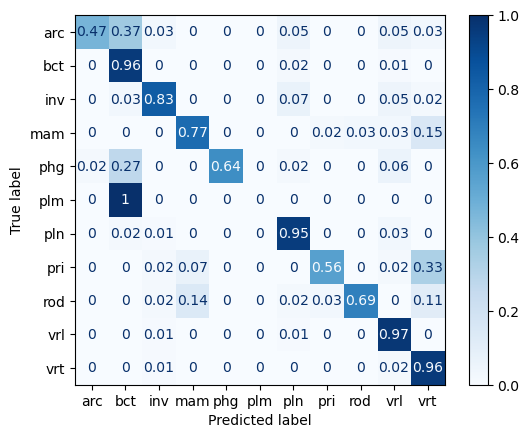

In [51]:
cm = confusion_matrix(y_test, y_pred)
# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.around(cm_normalized, decimals=2)

# Display the normalized and rounded confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=LabelEncoder().fit(df['Kingdom']).classes_)
disp.plot(cmap='Blues')
plt.show()

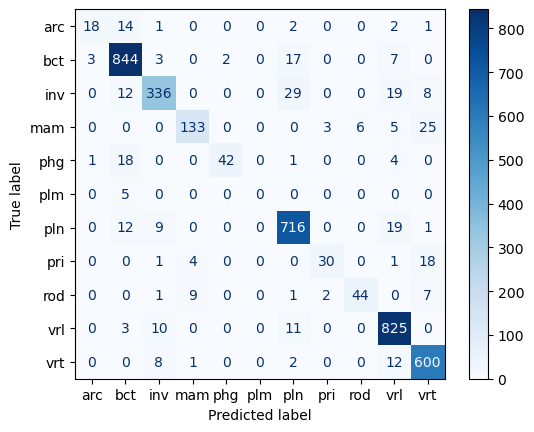

In [52]:
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LabelEncoder().fit(df['Kingdom']).classes_)
disp.plot(cmap='Blues')
plt.show()